In [2]:
import pandas as pd
import numpy as np
import re
import pyexasol
from random import randrange
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.power import tt_ind_solve_power, GofChisquarePower
from statsmodels.stats.gof import chisquare_effectsize
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.stats import norm, chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

import logging
from tqdm import tqdm

In [3]:
cred = pd.read_json(r'/Users/skostuchik/crd_exa.json')
user = cred.iloc[0, 0]
password = cred.iloc[0, 1]

C = pyexasol.connect(dsn='ex1..3.city-srv.ru:8563', user=user, password=password, fetch_dict=True)

In [4]:
ar_query = '''
with s as (
    select *
    from REPLICA.FAIRBOT_SUGGESTS_SUCCESS s
    where to_date(s.DATE_SUGGEST) between '2021-03-11' and '2021-04-11'
        and s.SUGGEST_TYPE = 4)
select s.ID_DRIVER DRIVER_RK, to_date(s.DATE_SUGGEST) dt,
    case when mod(UDF.CRC32(CONCAT(s.ID_DRIVER, 'fpr_checking')),100) < 50 then 'B' else 'A' end exp_group,
    1 suggest,
    case when s."ACTION" in (1,-2) then 1 else 0 end accept,
    case when s."ACTION" in (-1,-3) then 1 else 0 end "REJECT",
    case when s."ACTION" in (0,-4,-5) then 1 else 0 end fraud
from s
join emart."ORDER" oc on oc.ORDER_RK = s.ID_ORDER and oc.LOCALITY_RK = 2
'''

In [5]:
e_ar = C.execute(ar_query)

In [6]:
ar_suggest_data = pd.DataFrame(e_ar.fetchall())

In [7]:
ar_suggest_data.head()

,DRIVER_RK,DT,EXP_GROUP,SUGGEST,ACCEPT,REJECT,FRAUD
0,22903135,2021-03-11,A,1,0,1,0
1,22688323,2021-03-11,B,1,0,0,1
2,18035587,2021-03-11,A,1,1,0,0
3,10956418,2021-03-11,A,1,1,0,0
4,14026826,2021-03-11,A,1,1,0,0


In [8]:
len(ar_suggest_data)

18280886

<b>Total</b>

In [ ]:
p_result = {}

In [ ]:
a_s = len(ar_suggest_data[(ar_suggest_data['EXP_GROUP'] == 'A')&(ar_suggest_data['ACCEPT'] > 0)])
a_f = len(ar_suggest_data[(ar_suggest_data['EXP_GROUP'] == 'A')&(ar_suggest_data['ACCEPT'] == 0)])
b_s = len(ar_suggest_data[(ar_suggest_data['EXP_GROUP'] == 'B')&(ar_suggest_data['ACCEPT'] > 0)])
b_f = len(ar_suggest_data[(ar_suggest_data['EXP_GROUP'] == 'B')&(ar_suggest_data['ACCEPT'] == 0)])

successes = [a_s, b_s]
fails = [a_f,b_f]

p_val = chi2_contingency(np.array([fails, successes]))[1]
p_result.update({'AR':p_val})

In [ ]:
p_result

In [ ]:
mde_result = {}

alpha = 0.01
power = 0.9
n_bins = 2

In [ ]:
probs0, probs1 = np.array([a_s, a_f]), np.array([b_s, b_f])

effect_size = chisquare_effectsize(probs0, probs1, correction=None, cohen=True, axis=0)

res = int(GofChisquarePower().solve_power(effect_size=effect_size, alpha=alpha, power=power, n_bins=n_bins))

act_nobs_a = len(ar_suggest_data[ar_suggest_data['EXP_GROUP']=='A'])
act_nobs_b = len(ar_suggest_data[ar_suggest_data['EXP_GROUP']=='B'])

if (act_nobs_a>=res)&(act_nobs_b>=res):
    mde_marker_value = 1
else:
    mde_marker_value = np.nan

mde_result.update({'AR':{'needed':res, 'act_a':act_nobs_a, 'act_b':act_nobs_b,
                                'mde_ok':mde_marker_value}})

In [ ]:
mde_result

In [ ]:
metrics_values = {}

In [ ]:
a = ar_suggest_data[ar_suggest_data['EXP_GROUP']=='A']['ACCEPT'].sum()/ar_suggest_data[ar_suggest_data['EXP_GROUP']=='A']['SUGGEST'].sum()
b = ar_suggest_data[ar_suggest_data['EXP_GROUP']=='B']['ACCEPT'].sum()/ar_suggest_data[ar_suggest_data['EXP_GROUP']=='B']['SUGGEST'].sum()

lift = (b-a)/abs(a)

a_nobs = ar_suggest_data[ar_suggest_data['EXP_GROUP']=='A']['SUGGEST'].count()
b_nobs = ar_suggest_data[ar_suggest_data['EXP_GROUP']=='B']['SUGGEST'].count()
nobs_diff_value = (b_nobs-a_nobs)/abs(a_nobs)

metrics_values.update({'AR':{'split_a':a, 'split_b':b, 'lift':lift,
                             'a_nobs':a_nobs, 'b_nobs':b_nobs, 'nobs_diff':nobs_diff_value}})

In [ ]:
metrics_values

# False Positive Rate

In [20]:
stat_res_chi = {
    'aa': {'pvalue': []},
    'fpr': {f'fpr_0.99': .0}
}

In [21]:
stat_res_z = {
    'aa': {'pvalue': []},
    'fpr': {f'fpr_0.99': .0}
}

In [22]:
df_x = ar_suggest_data[ar_suggest_data['EXP_GROUP'] == 'A']
df_y = ar_suggest_data[ar_suggest_data['EXP_GROUP'] == 'B']

In [24]:
for sim in tqdm(range(10000)):
    x = df_x['ACCEPT'].sample(10000, replace=False)
    y = df_y['ACCEPT'].sample(10000, replace=False)

    a_s = x.sum()
    b_s = y.sum()
    a_nobs = x.count()
    b_nobs = y.count()
    a_f = a_nobs - a_s
    b_f = b_nobs - b_s
    
    successes, fails = [a_s, b_s], [a_f,b_f]
    count, nobs = np.array([a_s, b_s]), np.array([a_nobs, b_nobs])

    pvalue = chi2_contingency(np.array([fails, successes]))[1]
    stat_res_chi['aa']['pvalue'].append(pvalue)
    
    pval = proportions_ztest(count, nobs)[1]
    stat_res_z['aa']['pvalue'].append(pval)

100%|██████████| 10000/10000 [1:50:24<00:00,  1.51it/s]


In [25]:
def compute_fpr(pvalues: list):
    """
    Доля pvalues, соответствующих условию проверки

    Parameters
    ----------
    pvalues

    Returns
    -------

    """
    try:
        return float(sum(np.array(pvalues) <= 1 - 0.99) / 10000)
    except ValueError as e:
        logging.error(e)
        return None

In [26]:
stat_res_chi['fpr']['fpr_0.99'] = compute_fpr(pvalues=stat_res_chi['aa']['pvalue'])
stat_res_z['fpr']['fpr_0.99'] = compute_fpr(pvalues=stat_res_z['aa']['pvalue'])

In [27]:
stat_res_chi['fpr']

{'fpr_0.99': 0.0096}

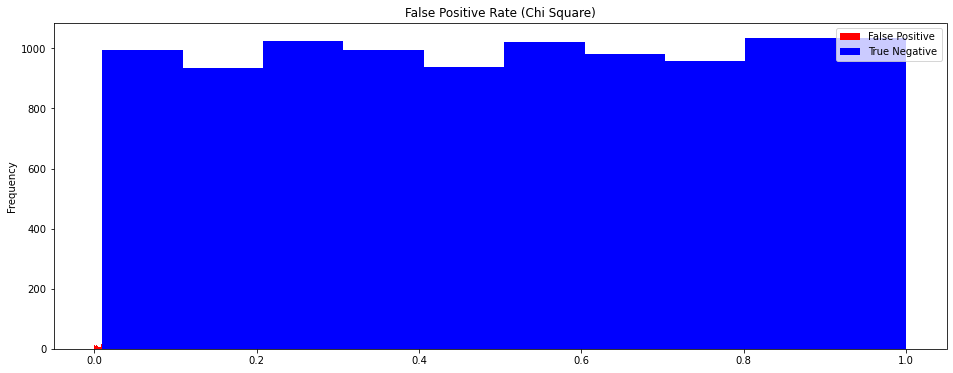

In [31]:
fpr_data = pd.DataFrame(stat_res_chi['aa']['pvalue'],columns=['pvalue'])

x1 = fpr_data[fpr_data['pvalue'] <= 0.01]
x2 = fpr_data[fpr_data['pvalue'] > 0.01]

plt.figure(figsize=(16,6))
plt.hist(x1, bins=10, color='r', label='False Positive')
plt.hist(x2, bins=10, color='b', label='True Negative')
plt.gca().set(title='False Positive Rate (Chi Square)', ylabel='Frequency')
plt.legend();

In [28]:
stat_res_z['fpr']

{'fpr_0.99': 0.0104}

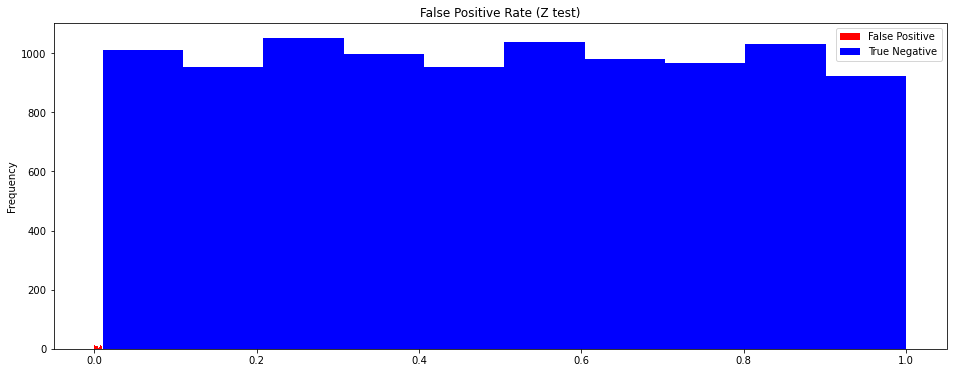

In [29]:
fpr_data = pd.DataFrame(stat_res_z['aa']['pvalue'],columns=['pvalue'])

x1 = fpr_data[fpr_data['pvalue'] <= 0.01]
x2 = fpr_data[fpr_data['pvalue'] > 0.01]

plt.figure(figsize=(16,6))
plt.hist(x1, bins=10, color='r', label='False Positive')
plt.hist(x2, bins=10, color='b', label='True Negative')
plt.gca().set(title='False Positive Rate (Z test)', ylabel='Frequency')
plt.legend();

# FPR на ограниченной выборке

In [ ]:
df_x_drivers = df_x.DRIVER_RK.unique()
df_y_drivers = df_y.DRIVER_RK.unique()

In [ ]:
a_sample_drivers = np.random.choice(df_x_drivers, 1000, replace=False)
b_sample_drivers = np.random.choice(df_y_drivers, 1000, replace=False)

In [ ]:
df_x_sample = df_x[df_x['DRIVER_RK'].isin(a_sample_drivers)]
df_y_sample = df_y[df_y['DRIVER_RK'].isin(b_sample_drivers)]

In [ ]:
print(len(df_x_sample),len(df_y_sample))

In [ ]:
stat_res_sampled = {
    'aa': {'pvalue': []},
    'fpr': {f'fpr_0.99': .0}
}

In [ ]:
for sim in tqdm(range(10000)):
    x = df_x_sample['ACCEPT'].sample(100000, replace=False)
    y = df_y_sample['ACCEPT'].sample(100000, replace=False)

    a_s = x.sum()
    a_f = len(x) - x.sum()
    b_s = y.sum()
    b_f = len(y) - y.sum()
    successes, fails = [a_s, b_s], [a_f,b_f]

    pvalue = chi2_contingency(np.array([fails, successes]))[1]
    stat_res_sampled['aa']['pvalue'].append(pvalue)

In [ ]:
stat_res_sampled['fpr']['fpr_0.99'] = compute_fpr(pvalues=stat_res['aa']['pvalue'])

In [ ]:
stat_res_sampled['fpr']

In [ ]:
ar_daily = ar_suggest_data[['DT','EXP_GROUP','ACCEPT','SUGGEST']].groupby(['DT','EXP_GROUP']).sum().reset_index()
ar_daily['ar'] = np.divide(ar_daily['ACCEPT'], ar_daily['SUGGEST'])

In [ ]:
ar_daily = ar_daily[['DT','EXP_GROUP','ar']].pivot_table(index=['DT'],columns=['EXP_GROUP'])

In [ ]:
#ar_daily.to_excel(r'ar_daily_aa.xlsx', sheet_name='daily_ar', index = True)